In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor,get_graph_node_names
import os 
import import_ipynb
from RetinaFPN import RetinaFPN as RetinaFPN

importing Jupyter notebook from RetinaFPN.ipynb


### Anchors
In every cell of the feature maps of different pyramid levels, generate 9 anchors. The following image is just to show as an example.
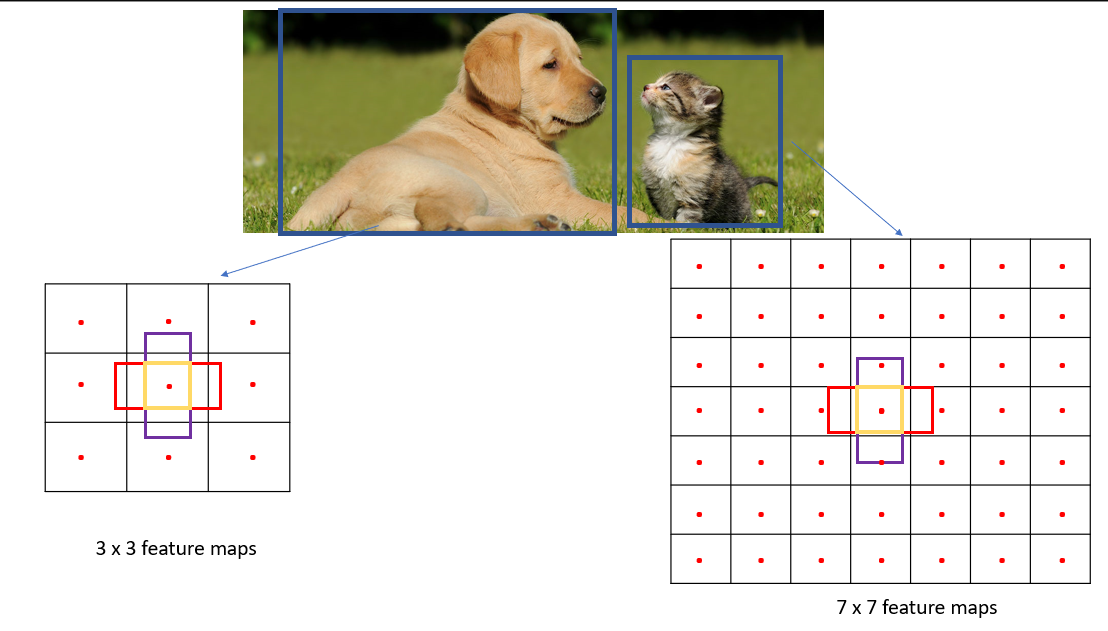

General step in generate_anchors step for each feature map:
1. Generate the normalized base anchors for that pyramid (center at x = 0, y = 0) 
2. Find all the center for every cell of the feature maps (which are the red dots)
2. For each normalized base anchor, sum it to the centers to get the x1,y1,x2,y2 


In [205]:
class Anchors(nn.Module):
    def __init__(self, features_size, pyramid_levels=None, ratios=None, scales=None):
        super(Anchors, self).__init__()
        if pyramid_levels is None: self.pyramid_levels = [3,4,5,6,7]
        else: self.pyramid_levels = pyramid_levels 
        if ratios is None: self.ratios = [0.5, 1, 2]
        else: self.ratios = ratios 
        if scales is None:self.scales = [2**0, 2**(1/3), 2**(2/3)]
        else: self.scales = scales
        
        self.strides = [2**x for x in self.pyramid_levels]
        self.areas = [32**2, 64**2, 128**2, 256**2, 512**2]
        self.feature_widths = features_size[:,2]
        self.feature_heights = features_size[:,3]
        
    def forward(self):
        all_anchors = np.zeros((0,4)).astype(np.float32)
        for ind, p in enumerate(self.pyramid_levels):
            base_anchors = self._generate_anchors(self.areas[ind], self.ratios, self.scales) #basic anchor in that layer
            layer_anchors = self.generate_anchors(self.feature_widths[ind], self.feature_heights[ind], self.strides[ind], base_anchors)
            all_anchors = np.append(all_anchors, layer_anchors, axis=0)
            
        all_anchors = np.expand_dims(all_anchors, axis= 0)
        #load the anchors to torch
        if torch.cuda.is_available():
            return torch.from_numpy(all_anchors.astype(np.float32)).cuda()
        else:
            return torch.from_numpy(all_anchors.astype(np.float32))

    def _generate_anchors(self, area, ratios, scales):
        num_anchors = len(ratios)*len(scales)
        anchors = []
        for scale in self.scales:
            # w*h= area and w = h*ratio
            # h^2*ratio = area -> h = sqrt(area/ratio) 
            for ratio in self.ratios:
                anchor_h = np.sqrt(area*scale/ratio)
                anchor_w = area*scale/anchor_h
                anchors.append([-anchor_w/2, -anchor_h/2, anchor_w/2, anchor_h/2])
        return np.array(anchors)
    
    def generate_anchors(self, feature_width, feature_height, stride, anchors):
        # map center for every cell on feature map to realistic image coordinate
        center_x = (np.arange(feature_width) + 0.5)*stride 
        center_y = (np.arange(feature_height) + 0.5)*stride
        
        center_xx, center_yy = np.meshgrid(center_x, center_y)
        centers = np.vstack((center_xx.ravel(), center_yy.ravel(),center_xx.ravel(),center_yy.ravel())).transpose()
        A = anchors.shape[0]
        K = centers.shape[0]
        
        # all_anchors is a K*A*4 matrix
        all_anchors = anchors.reshape((1, A, 4)) + np.expand_dims(centers, axis = 1)
        
        # shape it to (K*A, 4)
        all_anchors = all_anchors.reshape(K*A,4)

        return all_anchors

In [206]:
net = RetinaFPN()
x = net(torch.randn(1,3,600,600))
features_size = np.array([xx.shape for xx in x])
anchors = Anchors(features_size)
anchors()

tensor([[[  -7.3137,  -18.6274,   15.3137,   26.6274],
         [ -12.0000,  -12.0000,   20.0000,   20.0000],
         [ -18.6274,   -7.3137,   26.6274,   15.3137],
         ...,
         [1627.9299, 1399.8599, 2084.0701, 2312.1401],
         [1533.4602, 1533.4602, 2178.5398, 2178.5398],
         [1399.8599, 1627.9299, 2312.1401, 2084.0701]]])